In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read the words from the input file
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
print(len(words))

32033


In [6]:
# building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3

In [8]:
# building the data set based on the block size
def build_dataset(words):
    X,Y = [],[]
    for word in words:
        #print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[c] for c in context), "-->", ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,X.dtype, Y.shape, Y.dtype)
    return X,Y

In [9]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
# train split, dev/validation split, test split
# 80 %, 10%, 10%

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [65]:
# MLP revisited
n_embed = 10 # embeding dimensionality
n_hidden = 100 # number of hidden layer neurons of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),generator = g) * (5/3) / ((n_embed * block_size) ** 0.5) # Kainin Initialization techniqiue for Neural networks
#b1 = torch.randn(n_hidden, generator = g) * 0.02
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]



print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

6197


In [66]:
losses = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):
    # mini-batch selection
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # (batch_size, context, embedding_size)
    embcat = emb.view(-1, n_embed * block_size)
    hpreact = embcat @ W1 #+ b1 as its not required when batch normalization is used
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
             
    h = torch.tanh(hpreact) # hidden units
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    # update params
    for p in parameters:
        p.data += -lr * p.grad
    # track status
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 200000: 3.2903
  10000/ 200000: 2.2949
  20000/ 200000: 2.0504
  30000/ 200000: 1.9828
  40000/ 200000: 2.5438
  50000/ 200000: 1.9107
  60000/ 200000: 2.1125
  70000/ 200000: 2.2830
  80000/ 200000: 1.8073
  90000/ 200000: 1.9578
 100000/ 200000: 2.4820
 110000/ 200000: 1.9238
 120000/ 200000: 2.1720
 130000/ 200000: 1.9189
 140000/ 200000: 2.1879
 150000/ 200000: 1.8205
 160000/ 200000: 2.2668
 170000/ 200000: 1.8532
 180000/ 200000: 2.3656
 190000/ 200000: 1.8180


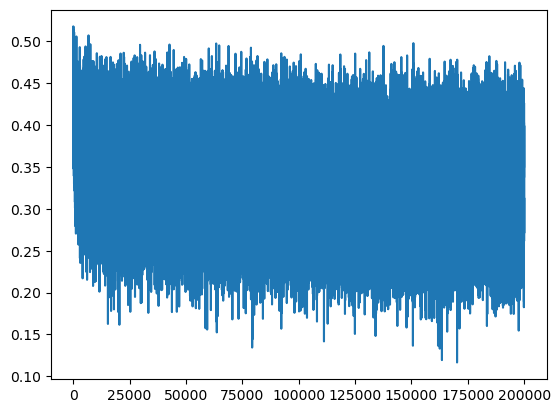

In [67]:
plt.plot(losses)

In [68]:
# calibrating the batch propagation for bngain and bnbias

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # (samples, 200)
    bnmean = hpreact.mean(0, keepdims = True)
    bnstd = hpreact.std(0, keepdims = True)

In [69]:
bnmean

tensor([[-3.5821,  1.6312, -1.2192,  2.2345, -1.5309, -1.3210, -1.3495, -1.5307,
         -0.7541, -0.5942, -1.5235, -0.7585,  0.9428,  0.1955, -0.2396,  0.0294,
          1.0260, -3.8266,  0.9605,  1.0506, -0.1892, -0.8367,  0.1177,  1.9622,
          0.0621,  0.2349,  1.7552, -1.0247, -2.0495, -0.9349,  0.1555, -0.7943,
         -1.6855,  0.2181, -0.9730, -0.9110, -0.3731, -0.6997,  0.1480, -1.8860,
         -0.6217,  0.7416,  0.6572, -1.2140,  0.3871, -1.7710, -0.2047,  0.8839,
          0.9942,  0.0401,  2.1592, -0.7369, -2.4369,  1.1389,  1.4153,  1.2352,
         -0.9456, -3.0892,  0.4137,  1.1734,  0.2095,  0.9146,  0.8700, -0.7517,
         -1.2514, -0.1419, -0.8536, -0.5000, -2.0479,  1.6176, -0.2584,  0.5427,
         -0.4181, -0.4919,  0.3669,  0.9476,  0.9463, -2.7407, -3.0017, -0.8526,
         -1.8042, -1.2369, -0.0640,  1.1783, -0.9637, -2.0654,  1.2586,  0.1822,
          1.1135, -0.1595,  1.6519, -0.3922,  0.3602, -1.0107, -2.1955,  2.6493,
         -1.0425, -2.2482, -

In [70]:
bnmean_running

tensor([[-3.5816,  1.6441, -1.2317,  2.2557, -1.5359, -1.3216, -1.3575, -1.5529,
         -0.7570, -0.6026, -1.5267, -0.7710,  0.9531,  0.1809, -0.2448,  0.0506,
          1.0464, -3.8590,  0.9692,  1.0469, -0.1943, -0.8249,  0.1295,  1.9521,
          0.0751,  0.2462,  1.7582, -1.0124, -2.0635, -0.9464,  0.1513, -0.7985,
         -1.6925,  0.2224, -0.9745, -0.8991, -0.3927, -0.7112,  0.1487, -1.8913,
         -0.6298,  0.7362,  0.6791, -1.2182,  0.3850, -1.7865, -0.1921,  0.8806,
          0.9933,  0.0383,  2.1727, -0.7561, -2.4615,  1.1437,  1.4296,  1.2336,
         -0.9533, -3.0843,  0.4167,  1.1678,  0.2078,  0.9243,  0.8451, -0.7575,
         -1.2415, -0.1555, -0.8586, -0.4886, -2.0375,  1.6234, -0.2525,  0.5548,
         -0.4120, -0.4665,  0.3600,  0.9479,  0.9485, -2.7392, -2.9913, -0.8485,
         -1.7998, -1.2267, -0.0556,  1.1847, -0.9663, -2.0795,  1.2409,  0.1984,
          1.1299, -0.1384,  1.6630, -0.4079,  0.3543, -1.0094, -2.1950,  2.6536,
         -1.0594, -2.2626, -

In [71]:
bnstd

tensor([[2.8180, 2.4748, 3.0287, 3.1279, 2.1526, 2.3352, 2.3529, 2.1135, 2.5701,
         2.3185, 2.2292, 3.0758, 2.4598, 2.8065, 2.2525, 2.4654, 3.0786, 2.3246,
         2.4720, 2.0715, 2.4687, 2.9102, 2.3043, 2.8024, 2.4278, 2.4877, 2.4479,
         2.6201, 2.4617, 2.4950, 2.0941, 2.6847, 2.8191, 2.3426, 2.3932, 2.4394,
         1.8422, 3.0718, 2.5007, 2.5256, 2.7132, 2.7222, 2.5417, 2.6529, 2.3591,
         2.5229, 2.3201, 3.2833, 2.1597, 2.2042, 2.5903, 2.4433, 2.9077, 2.3382,
         2.4572, 2.3563, 2.3439, 2.6009, 2.2476, 2.2485, 2.2956, 2.5970, 2.4911,
         2.6918, 2.5667, 2.6272, 2.2707, 2.2764, 3.0403, 2.7084, 2.4448, 2.7306,
         1.9366, 2.4019, 2.4059, 2.5929, 2.5333, 2.2488, 3.2356, 1.9410, 2.4995,
         2.5661, 2.3935, 2.4057, 2.2621, 2.5013, 2.7716, 2.1988, 2.5033, 2.6643,
         2.5174, 2.6439, 2.5734, 3.1993, 2.5550, 2.3927, 2.2067, 2.6088, 2.3479,
         2.3918]])

In [72]:
bnstd_running

tensor([[2.8010, 2.4469, 2.9790, 3.1158, 2.1250, 2.3137, 2.3131, 2.0779, 2.5444,
         2.2954, 2.2033, 3.0558, 2.4500, 2.7770, 2.2277, 2.4438, 3.0567, 2.3047,
         2.4660, 2.0455, 2.4392, 2.8966, 2.2795, 2.7667, 2.4155, 2.4671, 2.4316,
         2.5924, 2.4521, 2.4595, 2.0620, 2.6672, 2.7995, 2.3285, 2.3785, 2.4169,
         1.8324, 3.0271, 2.4771, 2.5021, 2.7023, 2.7028, 2.5087, 2.6166, 2.3477,
         2.4966, 2.2960, 3.2242, 2.1353, 2.1882, 2.5511, 2.4130, 2.8806, 2.3038,
         2.4326, 2.3265, 2.3287, 2.5806, 2.2304, 2.2137, 2.2802, 2.5480, 2.4684,
         2.6631, 2.5387, 2.5968, 2.2445, 2.2600, 3.0274, 2.6774, 2.4403, 2.7238,
         1.9206, 2.3835, 2.3791, 2.5610, 2.5087, 2.2107, 3.2322, 1.9133, 2.4862,
         2.5409, 2.3605, 2.3807, 2.2201, 2.4833, 2.7397, 2.1694, 2.4639, 2.6407,
         2.4828, 2.6074, 2.5409, 3.1836, 2.5461, 2.3679, 2.1826, 2.5918, 2.3209,
         2.3454]])

In [73]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 not required 
    #hpreact = bngain * ((hpreact - hpreact.mean(0, keepdims=True)) / (hpreact.std(0, keepdims=True))) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.114677906036377
val 2.1412901878356934


In [23]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0]* block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mili.
thiyah.
cassie.
rahnel.
delynn.
jareen.
ner.
kentzerian.
kaleigh.
ham.
join.
quintzonor.
raiviani.
watell.
dearyxiann.
evedrra.
med.


##### Pytorchifying the Code

In [134]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else :
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

In [147]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters) )
for p in parameters:
    p.requires_grad = True

47351


In [148]:
losses = []
max_steps = 200000
batch_size = 32
ud = []
for i in range(max_steps):
    # mini-batch selection
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]     
    x= emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    # update params
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i>1000:
        break

      0/ 200000: 3.3012


layer 1 (<class '__main__.Tanh'>): mean -0.07, std 0.77, saturated: 23.50%
layer 4 (<class '__main__.Tanh'>): mean +0.00, std 0.64, saturated: 2.47%
layer 7 (<class '__main__.Tanh'>): mean -0.00, std 0.64, saturated: 2.09%
layer 10 (<class '__main__.Tanh'>): mean -0.01, std 0.65, saturated: 2.34%
layer 13 (<class '__main__.Tanh'>): mean +0.00, std 0.64, saturated: 1.84%


Text(0.5, 1.0, 'activation distribution')

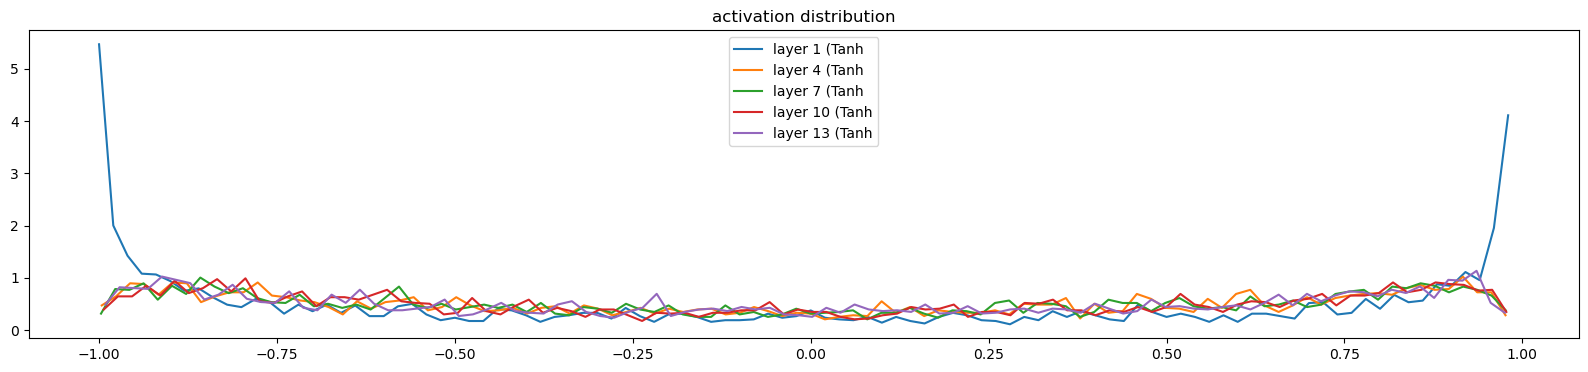

In [149]:
# visualize histograms
plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%'% (i, layer.__class__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);     
plt.title('activation distribution')

layer 1 (<class '__main__.Tanh'>): mean 0.000000, std 3.262753e-03
layer 4 (<class '__main__.Tanh'>): mean -0.000000, std 2.980984e-03
layer 7 (<class '__main__.Tanh'>): mean 0.000000, std 2.726867e-03
layer 10 (<class '__main__.Tanh'>): mean 0.000000, std 2.613569e-03
layer 13 (<class '__main__.Tanh'>): mean 0.000000, std 2.545886e-03


Text(0.5, 1.0, 'gradient distribution')

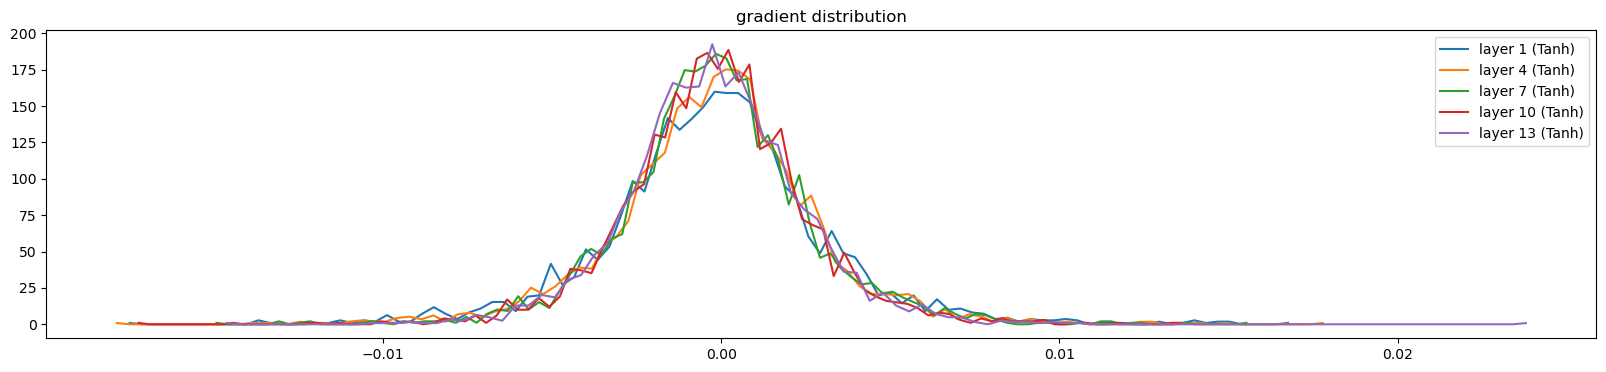

In [153]:
# visualize histograms
plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %f, std %e'% (i, layer.__class__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);     
plt.title('gradient distribution')

weights   (27, 10) | mean +0.000055 | std 9.298457e-03 | grad:data ratio 9.289961e-03
weights  (30, 100) | mean -0.000082 | std 9.036817e-03 | grad:data ratio 2.890264e-02
weights (100, 100) | mean +0.000058 | std 7.136941e-03 | grad:data ratio 4.268701e-02
weights (100, 100) | mean -0.000003 | std 5.842932e-03 | grad:data ratio 3.464607e-02
weights (100, 100) | mean -0.000033 | std 5.477282e-03 | grad:data ratio 3.263605e-02
weights (100, 100) | mean -0.000007 | std 5.483734e-03 | grad:data ratio 3.266373e-02
weights  (100, 27) | mean -0.000032 | std 9.852612e-03 | grad:data ratio 5.912252e-02


Text(0.5, 1.0, 'weight gradient distribution')

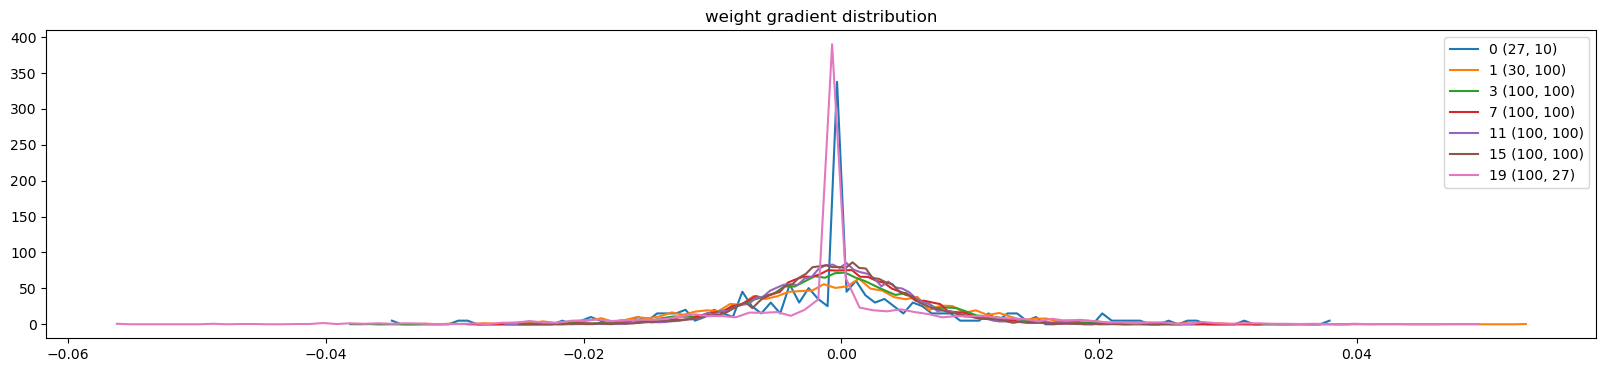

In [154]:
plt.figure(figsize = (20,4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weights %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distribution')

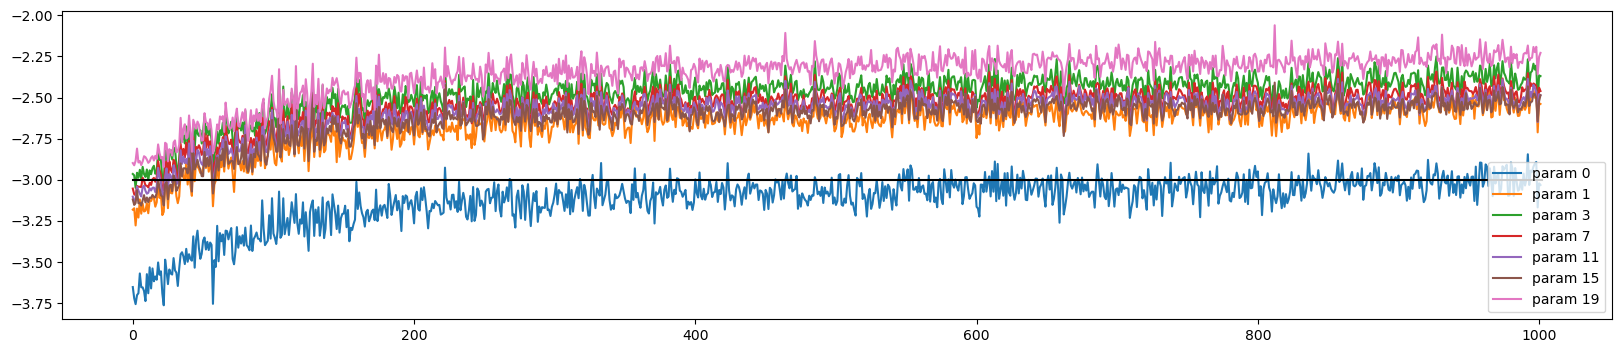

In [155]:
plt.figure(figsize = (20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be less 1e-3, indicated on plot
plt.legend(legends)